<a href="https://colab.research.google.com/github/tvpian/LLM_FineTuning_Series/blob/main/LLM_FineTuning_Series_01_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [2]:
import openai

In [3]:
from openai import OpenAI

In [4]:
help(OpenAI)

Help on class OpenAI in module openai:

class OpenAI(openai._base_client.SyncAPIClient)
 |  OpenAI(*, api_key: 'str | None' = None, organization: 'str | None' = None, project: 'str | None' = None, base_url: 'str | httpx.URL | None' = None, timeout: 'Union[float, Timeout, None, NotGiven]' = NOT_GIVEN, max_retries: 'int' = 2, default_headers: 'Mapping[str, str] | None' = None, default_query: 'Mapping[str, object] | None' = None, http_client: 'httpx.Client | None' = None, _strict_response_validation: 'bool' = False) -> 'None'
 |  
 |  Method resolution order:
 |      OpenAI
 |      openai._base_client.SyncAPIClient
 |      openai._base_client.BaseClient
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, api_key: 'str | None' = None, organization: 'str | None' = None, project: 'str | None' = None, base_url: 'str | httpx.URL | None' = None, timeout: 'Union[float, Timeout, None, NotGiven]' = NOT_GIVEN, max_retries: 'int' = 2, default_head

In [5]:
client = OpenAI(api_key='')


In [6]:
# Environment Variable
import os
os.environ['OPENAI_API_KEY'] = ''


In [7]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who won the world series in 2020?"},
    {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    {"role": "user", "content": "Where was it played?"}
  ]
)

In [8]:
print(response.choices[0].message.content)

The World Series in 2020 was played at Globe Life Field in Arlington, Texas.


In [9]:
import pandas as pd

In [11]:
medical_reports = pd.read_csv('reports.csv')

In [12]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [13]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


### Data Preprocessing

*   Droping rows with missing values
*   Uniform sampling to ensure the number of samples from each category is same across train, validation and test set




In [14]:
# Drop the missing rows
# Drop the duplicate rows
# Drop the columns
medical_reports = medical_reports.dropna(subset=['report'])

In [15]:
medical_reports.groupby('medical_specialty').count()

,report
medical_specialty,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223
Radiology,273
Surgery,1088


In [16]:
# Uniform sampling from all categories
# Train, Validation and Test set

grouped_data = medical_reports.groupby('medical_specialty').sample(110, random_state=42)

In [17]:
grouped_data['medical_specialty'].value_counts()

medical_specialty
Cardiovascular / Pulmonary    110
Gastroenterology              110
Neurology                     110
Radiology                     110
Surgery                       110
Name: count, dtype: int64

In [18]:
val_test_data = grouped_data.groupby('medical_specialty').sample(10, random_state=42)

In [19]:
val = val_test_data.groupby('medical_specialty').head(5)
test = val_test_data.groupby('medical_specialty').tail(5)

In [20]:
train = grouped_data.drop(val.index).drop(test.index)

### Data Processing


*   Computing the statastics of the split data to prevent unwanted biases that could potentially arise from the data splitting



In [21]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00


In [22]:
import tiktoken

In [23]:
def num_tokens_from_messages(string: str, model: str = "gpt-3.5-turbo") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [24]:
num_tokens_from_messages("hello how are you")

4

In [25]:
# Compute the length of the tokens for the report
report_length = train["report"].apply(num_tokens_from_messages)

In [26]:
report_length.describe()

count     500.000000
mean      674.788000
std       427.809075
min        14.000000
25%       358.000000
50%       593.500000
75%       904.000000
max      3701.000000
Name: report, dtype: float64

In [27]:
total_number_of_tokens = sum(report_length)

In [28]:
# Calculating the estimated pricing for fine-tuning(training) the model
price_model = 1.5
price_per_epoch = price_model * total_number_of_tokens / 1000000
price_per_epoch

0.506091

### Data Formatting

In [29]:
train["medical_specialty"].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [30]:
# System Prompt
# User --> report
# Assistant --> medical_speciality

In [31]:
system_prompt = "Given the medical description report, classify it into one of the following categories: "+"\n"+"Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

In [33]:
sample_prompt = {"messages": [{'role':'system','content':system_prompt},
                              {'role':'user','content':train['report'].iloc[0]},
                              {'role':'assistant','content':train['medical_specialty'].iloc[0]}]}

In [36]:
sample_prompt

{'messages': [{'role': 'system',
   'content': 'Given the medical description report, classify it into one of the following categories: \nCardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'},
  {'role': 'user',
   'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom. 

In [37]:
def df_to_format(df):
  formmatted_data = []

  for index, row in df.iterrows():
    prompt = {"messages": [{'role':'system','content':system_prompt},
                              {'role':'user','content':row['report']},
                              {'role':'assistant','content':row['medical_specialty']}]}
    formmatted_data.append(prompt)

  return formmatted_data

In [38]:
data = df_to_format(train)

In [39]:
data[10]

{'messages': [{'role': 'system',
   'content': 'Given the medical description report, classify it into one of the following categories: \nCardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'},
  {'role': 'user',
   'content': "OPERATION: , Subxiphoid pericardial window.,ANESTHESIA: , General endotracheal anesthesia.,OPERATIVE PROCEDURE IN DETAIL:  ,After obtaining informed consent from the patient's family, including a thorough explanation of the risks and benefits of the aforementioned procedure, patient was taken to the operating room and general endotracheal anesthesia was administered.  Next, the neck and chest were prepped and draped in the standard surgical fashion.  A #10-blade scalpel was used to make an incision in the area of the xiphoid process.  Dissection was carried down to the level of the fascia using Bovie electrocautery.  The xiphoid process was elevated, and the diaphragmatic attachments to it were dissected free.  Next the pericardium was ide

In [40]:
import json

In [43]:
with open('fine_tuning_data_train.jsonl', 'w') as f:
  for item in data:
    json.dump(item, f)
    f.write('\n')

In [44]:
data_val = df_to_format(val)

In [45]:
with open('fine_tuning_data_val.jsonl', 'w') as f:
  for item in data_val:
    json.dump(item, f)
    f.write('\n')

### Training


In [46]:
client = OpenAI()

In [47]:
file_upload_response = client.files.create(
  file=open('fine_tuning_data_train.jsonl', 'rb'),
  purpose='fine-tune')

In [48]:
file_upload_response

FileObject(id='file-uXodvg3S6U0LdrNVg5gipOlD', bytes=1547622, created_at=1717870502, filename='fine_tuning_data_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [49]:
file_upload_response_val = client.files.create(
  file=open('fine_tuning_data_val.jsonl', 'rb'),
  purpose='fine-tune')

In [50]:
file_upload_response_val

FileObject(id='file-CxZSX81MSccDbKt4iuZUWg7E', bytes=101684, created_at=1717870548, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [57]:
fine_tuning_reponse = client.fine_tuning.jobs.create(
  training_file=file_upload_response.id,
  validation_file=file_upload_response_val.id,
  model='gpt-3.5-turbo',
  hyperparameters={
      'n_epochs': 1
  }
)

In [66]:
fine_tuning_reponse

FineTuningJob(id='ftjob-MlXWu4lbqQcplwAE0Ae3xOtL', created_at=1717870907, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-JrMMAShV5VePDAsjEgWFFWmU', result_files=[], seed=516468368, status='validating_files', trained_tokens=None, training_file='file-uXodvg3S6U0LdrNVg5gipOlD', validation_file='file-CxZSX81MSccDbKt4iuZUWg7E', estimated_finish=None, integrations=[], user_provided_suffix=None)

In [62]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-MlXWu4lbqQcplwAE0Ae3xOtL', created_at=1717870907, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-JrMMAShV5VePDAsjEgWFFWmU', result_files=[], seed=516468368, status='running', trained_tokens=None, training_file='file-uXodvg3S6U0LdrNVg5gipOlD', validation_file='file-CxZSX81MSccDbKt4iuZUWg7E', estimated_finish=1717872011, integrations=[], user_provided_suffix=None)], object='list', has_more=False)

In [67]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_reponse.id,
                                                  limit = 500,
)

In [72]:
train_event.data[2].data

{'step': 301,
 'train_loss': 6.35782896551973e-07,
 'total_steps': 500,
 'train_mean_token_accuracy': 1.0}

In [76]:
train_loss = []
val_loss = []
for event in train_event.data:
 train_data = event.data
 if train_data and 'train_loss' in train_data:
   train_loss.append(train_data['train_loss'])
 if train_data and 'validation_loss' in train_data:
   val_loss.append(train_data['validation_loss'])

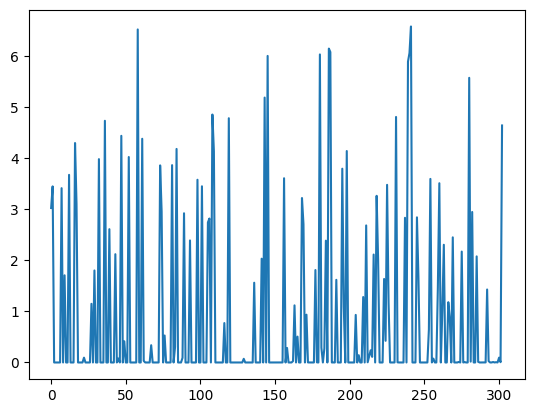

In [77]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()


### Testing the custom model

In [85]:
completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0125:tvpian::9XvGmgmH",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": test['report'].iloc[1]}
  ]
)


In [86]:
completion.choices[0].message.content

'Cardiovascular / Pulmonary'

In [87]:
test['medical_specialty'].iloc[1]

'Cardiovascular / Pulmonary'

In [88]:
def classify_report(report, model='ft:gpt-3.5-turbo-0125:tvpian::9XvGmgmH'):
  completion = client.chat.completions.create(
  model=model,
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": report}
  ]
  )
  return completion.choices[0].message.content

In [92]:
predicted_classes = []
ground_truth = []
for index, row in test.iterrows():
  predicted_classes.append(classify_report(row['report'].strip()))
  ground_truth.append(row['medical_specialty'].strip())

In [90]:
predicted_classes, ground_truth

(['Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Surgery',
  'Gastroenterology',
  'Radiology',
  'Gastroenterology',
  'Gastroenterology',
  'Gastroenterology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Radiology',
  'Gastroenterology',
  'Neurology',
  'Cardiovascular / Pulmonary',
  'Neurology',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Surgery',
  'Surgery',
  'Cardiovascular / Pulmonary'],
 ['Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Cardiovascular / Pulmonary',
  'Gastroenterology',
  'Gastroenterology',
  'Gastroenterology',
  'Gastroenterology',
  'Gastroenterology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Neurology',
  'Radiology',
  'Radiology',
  'Radiology',
  'Radiology',
  'Radiology',
  'Surgery',
  'Surgery',
  'Surgery',


In [93]:
import numpy as np
from sklearn.metrics import accuracy_score
accuracy_score(predicted_classes, ground_truth)

0.64